In [83]:
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import imageio
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from numpy.random import randn
from numpy.random import randint
import tensorflow as tf

In [84]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [85]:
# # Configure TensorFlow to use GPU memory growth
# gpus = tf.config.list_physical_devices('GPU')
# if gpus:
#     try:
#         for gpu in gpus:
#             tf.config.experimental.set_memory_growth(gpu, True)
#     except RuntimeError as e:
#         print(e)

In [86]:
n_images = 319
batch_size = 32
latent_dim = 100
n_epoch = 100
img_shape = (224,224, 3)

In [87]:
data_dir = 'C:\\Users\\Admin\\Documents\\osteoscarcoma_model_evaluation\\artifacts\\train\\Non-Tumor' 
images = os.listdir(data_dir)
images = images[:n_images]

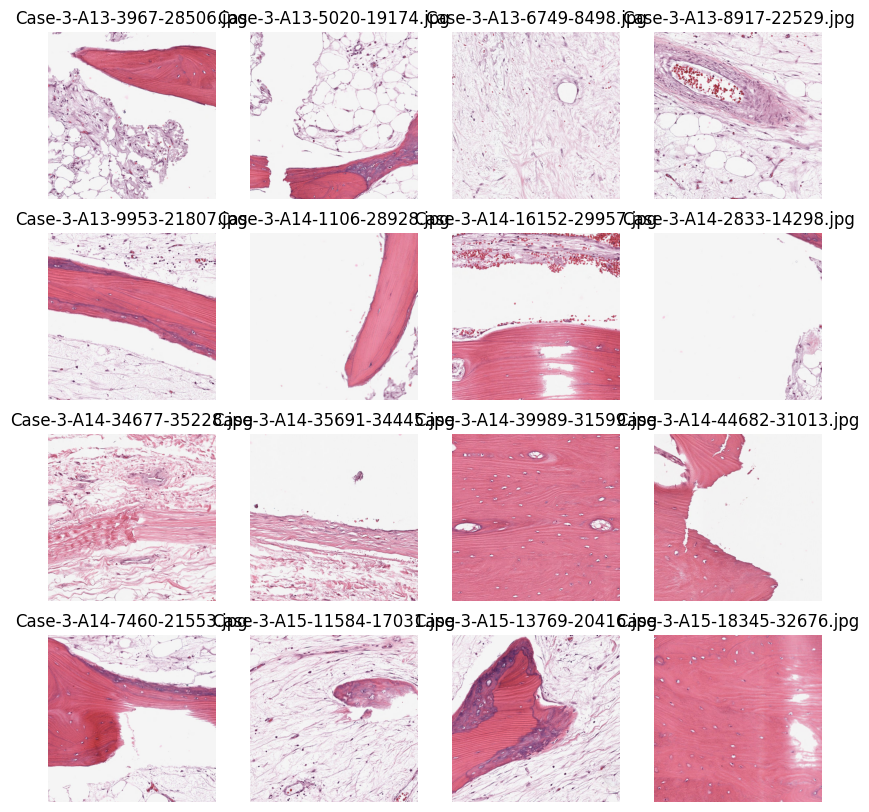

In [88]:
plt.figure(figsize=(10,10))
for i, name in enumerate(images[16:32]):
    plt.subplot(4, 4, i + 1)
    img = plt.imread(data_dir + '/' + name)
    plt.imshow(img)
    plt.title(name)
    plt.axis('off')

In [89]:
def get_data(data_path) :
    X = []
    for filename in data_path :
        img = img_to_array(load_img(data_dir + "/" + filename, target_size = img_shape[:2]))
        X.append(img)
    X = np.array(X).astype('float32')
    #X = (X - 127.5) / 127.5
    X = X / 255
    return X

dataset = get_data(images)

In [90]:

def define_discriminator(in_shape=(224,224,3)):
    model = Sequential()
    # normal
    model.add(Conv2D(128, (5,5), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(negative_slope=0.2))
    # downsample to 112x112
    model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # downsample to 56x56
    model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # downsample to 28x28
    model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # downsample to 14x14
    model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # classifier
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [91]:
def define_generator(latent_dim):
    model = Sequential()
    # foundation for 14x14 feature maps
    n_nodes = 128 * 14 * 14
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(negative_slope=0.2))
    model.add(Reshape((14, 14, 128)))
    # upsample to 28x28
    model.add(Conv2DTranspose(128, (5,5), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 56x56
    model.add(Conv2DTranspose(128, (5,5), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 112x112
    model.add(Conv2DTranspose(128, (5,5), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 224x224
    model.add(Conv2DTranspose(128, (5,5), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # output layer 224x224x3
    model.add(Conv2D(3, (5,5), activation='tanh', padding='same'))
    return model

# input of G
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = g_model.predict(x_input)
    # create 'fake' class labels (0)
    y = np.zeros((n_samples, 1))
    return X, y

In [92]:
def define_gan(g_model, d_model):
    # Make weights in the discriminator not trainable
    d_model.trainable = False
    # Connect generator and discriminator
    model = Sequential()
    model.add(g_model)
    model.add(d_model)
    # Compile the GAN model
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)  # Using binary cross-entropy loss
    return model



# retrive real samples
def get_real_samples(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # set 'real' class labels (1)
    y = np.ones((n_samples, 1))
    return X, y

# create and save a plot of generated images
def show_generated(generated,epoch, n=5):
    #[-1,1] -> [0,1] 
    #generated = (generated + 1)/ 2
    #generated = (generated[:n*n] * 127.5) + 127.5
    #generated = generated * 255
    plt.figure(figsize=(10,10))
    for i in range(n * n):
        plt.subplot(n, n, i + 1)
        #img = plt.imread(data_dir + '/' + name)
        plt.imshow(generated[i])
        #plt.title(name)
        plt.axis('off')
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch+1))
    plt.show()    

# evaluate the discriminator and plot generated images
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
    # prepare real samples
    X_real, y_real = get_real_samples(dataset, n_samples)
    # evaluate discriminator on real examples
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    # evaluate discriminator on fake examples
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print('>Accuracy [real: %.0f%%, fake: %.0f%%]' % (acc_real*100, acc_fake*100))
    # show plot
    show_generated(x_fake, epoch)    

In [93]:
def train(g_model, d_model, gan_model, dataset, latent_dim=100, n_epochs=100, n_batch=32):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    start = time.time()
    for i in range(n_epochs):
        with tf.device('/GPU:0'):
            # enumerate batches over the training set
            for j in range(bat_per_epo):
                # get randomly selected 'real' samples
                ix = np.random.randint(0, dataset.shape[0], half_batch)
                X_real, y_real = dataset[ix], np.ones((half_batch, 1))
                # generate 'fake' examples
                X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
                # update discriminator model weights
                d_loss1 = d_model.train_on_batch(X_real, y_real)
                d_loss2 = d_model.train_on_batch(X_fake, y_fake)
                # prepare points in latent space as input for the generator
                X_gan = generate_latent_points(latent_dim, n_batch)
                # create inverted labels for the fake samples
                y_gan = np.ones((n_batch, 1))
                # update the generator via the discriminator's error
                g_loss = gan_model.train_on_batch(X_gan, y_gan)
            # summarize loss on this batch
            print('Epoch: %d,  Loss: D_real = %.3f, D_fake = %.3f,  G = %.3f' % (i+1, np.mean(d_loss1), np.mean(d_loss2), g_loss))
            # evaluate the model performance
            if (i+1) % 10 == 0:
                summarize_performance(i, g_model, d_model, dataset, latent_dim)
    print ('Total time for training {} epochs is {} sec'.format(n_epochs, (time.time()-start)))


In [94]:
discriminator = define_discriminator()
generator = define_generator(latent_dim)

# create the gan
gan = define_gan(generator, discriminator)

# train model
train(generator, discriminator, gan, dataset, latent_dim, n_epoch, batch_size)

## TODO: Get better output images!

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step


InternalError: Graph execution error:

Detected at node 'StatefulPartitionedCall' defined at (most recent call last):
    File "c:\Users\Admin\anaconda3\envs\tf\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\Admin\anaconda3\envs\tf\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\Admin\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "c:\Users\Admin\anaconda3\envs\tf\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "c:\Users\Admin\anaconda3\envs\tf\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "c:\Users\Admin\anaconda3\envs\tf\lib\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\Admin\anaconda3\envs\tf\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\Users\Admin\anaconda3\envs\tf\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "c:\Users\Admin\anaconda3\envs\tf\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\Admin\anaconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "c:\Users\Admin\anaconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "c:\Users\Admin\anaconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "c:\Users\Admin\anaconda3\envs\tf\lib\site-packages\ipykernel\ipkernel.py", line 359, in execute_request
      await super().execute_request(stream, ident, parent)
    File "c:\Users\Admin\anaconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "c:\Users\Admin\anaconda3\envs\tf\lib\site-packages\ipykernel\ipkernel.py", line 446, in do_execute
      res = shell.run_cell(
    File "c:\Users\Admin\anaconda3\envs\tf\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\Admin\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3048, in run_cell
      result = self._run_cell(
    File "c:\Users\Admin\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3103, in _run_cell
      result = runner(coro)
    File "c:\Users\Admin\anaconda3\envs\tf\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\Admin\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3308, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\Admin\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3490, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\Admin\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3550, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Admin\AppData\Local\Temp\ipykernel_13708\2296628547.py", line 8, in <module>
      train(generator, discriminator, gan, dataset, latent_dim, n_epoch, batch_size)
    File "C:\Users\Admin\AppData\Local\Temp\ipykernel_13708\900249933.py", line 16, in train
      d_loss1 = d_model.train_on_batch(X_real, y_real)
    File "c:\Users\Admin\anaconda3\envs\tf\lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 551, in train_on_batch
      logs = self.train_function(data())
    File "c:\Users\Admin\anaconda3\envs\tf\lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 118, in one_step_on_iterator
      outputs = self.distribute_strategy.run(
Node: 'StatefulPartitionedCall'
libdevice not found at ./libdevice.10.bc
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_one_step_on_iterator_21175]